# **Notebook: Métricas para evaluar modelos (con datos simulados)**

Este notebook muestra cómo evaluar modelos en **regresión** y **clasificación**, usando datos sintéticos.
Incluye: split train/test, baseline, métricas principales y gráficos (ROC/PR, residuales, etc.).

> Requisitos: numpy, pandas, matplotlib, scikit-learn

# Métricas para evaluar modelos en Machine Learning

Evaluar un modelo en Machine Learning significa cuantificar **qué tan bien generaliza** a datos nuevos y **qué tipo de errores comete**. Las métricas dependen del tipo de problema (regresión, clasificación, clustering, ranking, etc.) y del objetivo real (costos, riesgo, equidad, calibración). En general, no existe una “mejor métrica universal”: la métrica correcta debe alinearse con **lo que importa en el caso de uso**.

---

## 1) Métricas para **Regresión** (salida continua)

Estas métricas comparan valores reales $y$ vs predicciones $\hat{y}$.

### Errores en escala original
- **MAE (Mean Absolute Error)**  
  Promedio del error absoluto:  
  $$
  \text{MAE}=\frac{1}{n}\sum |y_i-\hat{y}_i|
  $$  
  *Interpretación*: “en promedio me equivoco en X unidades”.

- **RMSE (Root Mean Squared Error)**  
  Raíz del MSE; penaliza más los errores grandes:  
  $$
  \text{RMSE}=\sqrt{\frac{1}{n}\sum (y_i-\hat{y}_i)^2}
  $$  
  *Útil* cuando errores grandes son especialmente costosos.

- **MSE (Mean Squared Error)**  
  Similar a RMSE pero en unidades cuadradas; útil para optimización.

### Métricas relativas y de ajuste
- **$R^2$ (Coeficiente de determinación)**  
  Proporción de varianza explicada por el modelo:  
  $$
  R^2 = 1 - \frac{\sum (y_i-\hat{y}_i)^2}{\sum (y_i-\bar{y})^2}
  $$  
  *Ojo*: puede ser engañoso fuera del dominio de entrenamiento o si hay sesgos sistemáticos.

- **MAPE (Mean Absolute Percentage Error)**  
  Error porcentual medio absoluto:  
  $$
  \text{MAPE}=\frac{100}{n}\sum \left|\frac{y_i-\hat{y}_i}{y_i}\right|
  $$  
  *Ojo*: falla si $y_i$ puede ser 0 o muy pequeño.

### Robustas a outliers
- **MedAE (Median Absolute Error)**  
  Mediana de $|y-\hat{y}|$; menos sensible a outliers.

---

## 2) Métricas para **Clasificación** (salida discreta)

En clasificación hay dos niveles:
1) **Etiquetas predichas** $\hat{y}$ (depende de un umbral si es binaria).
2) **Scores/probabilidades** $\hat{p}$ (ranking y calibración).

### Métricas basadas en la matriz de confusión (binaria)
Con:
- **TP**: verdaderos positivos, **FP**: falsos positivos  
- **TN**: verdaderos negativos, **FN**: falsos negativos

- **Accuracy**  
  $$
  \frac{TP+TN}{TP+TN+FP+FN}
  $$  
  *Útil* si las clases están balanceadas; *peligrosa* con desbalance.

- **Precision** (qué tan “limpios” son los positivos detectados)  
  $$
  \text{Prec}=\frac{TP}{TP+FP}
  $$

- **Recall / Sensitivity / TPR** (cuántos positivos capturo)  
  $$
  \text{Rec}=\frac{TP}{TP+FN}
  $$

- **Specificity / TNR** (cuántos negativos rechazo bien)  
  $$
  \text{Spec}=\frac{TN}{TN+FP}
  $$

- **F1-score** (balance entre precision y recall)  
  $$
  F1 = 2\frac{\text{Prec}\cdot \text{Rec}}{\text{Prec}+\text{Rec}}
  $$  
  (También existen **F$_\beta$** para ponderar más recall o precision.)

- **Balanced Accuracy**  
  Promedio de TPR y TNR; útil con desbalance.

### Métricas basadas en probabilidades (ranking)
- **ROC-AUC**  
  Área bajo la curva ROC; mide capacidad de ranking entre clases.  
  *Ojo*: con clases muy raras puede verse “optimista”.

- **PR-AUC / Average Precision**  
  Área bajo precision–recall; suele ser más informativa cuando la clase positiva es rara.

- **Log Loss (Cross-Entropy)**  
  Penaliza probabilidades mal calibradas: si el modelo está “muy seguro” y se equivoca, castiga mucho.

### Multiclase
- Se usan versiones **macro**, **micro** y **weighted** de precision/recall/F1.
- **Top-k accuracy** (muy común en visión/NLP).

---

## 3) Métricas de **Calibración** (cuando importan probabilidades “bien dichas”)

No basta con clasificar bien; a veces importa que “0.8” signifique realmente 80%:

- **Brier Score** (binaria): error cuadrático de probabilidades.  
- **Calibration curve / Reliability diagram**: diagnóstico visual.
- (Relacionado) **Expected Calibration Error (ECE)**: resumen de descalibración.

---

## 4) Métricas para **Clustering / No supervisado** (si no hay etiquetas)

- **Silhouette score**: cohesión vs separación.
- **Davies–Bouldin index**, **Calinski–Harabasz**: criterios internos.
- Con etiquetas externas: **ARI** (Adjusted Rand Index), **NMI** (Normalized Mutual Information).

---

## 5) ¿Cómo escoger una métrica? (regla práctica)

- Si el error se mide en unidades reales → **MAE/RMSE** (regresión).
- Si hay desbalance o costos asimétricos → **precision/recall/F1, PR-AUC** (clasificación).
- Si importan probabilidades confiables → **log loss + calibración**.
- Si el costo de errores es explícito → define una **métrica de costo** o una utilidad esperada.

---

## 6) Buenas prácticas mínimas

- Reportar métricas en **test** o con **cross-validation** (no solo training).
- Comparar contra un **baseline**.
- Acompañar métricas con al menos un gráfico diagnóstico:
  - regresión: residuales, predicho vs real
  - clasificación: matriz de confusión, ROC/PR, curva de calibración
- Evitar **data leakage**: una mala evaluación “infla” métricas y da falsa confianza.


In [1]:
# =========================================================
# Simulación + evaluación de métricas (Regresión y Clasificación)
# =========================================================
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression, make_classification
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, median_absolute_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score,
    roc_auc_score, average_precision_score, log_loss, brier_score_loss, confusion_matrix
)
from sklearn.linear_model import LinearRegression, LogisticRegression

np.random.seed(7)

# ---------------------------------------------------------
# Helpers: métricas de regresión y clasificación
# ---------------------------------------------------------
def regression_metrics(y_true, y_pred, eps=1e-12):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    mae  = mean_absolute_error(y_true, y_pred)
    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2   = r2_score(y_true, y_pred)
    medae = median_absolute_error(y_true, y_pred)

    # MAPE (cuidado con ceros)
    denom = np.maximum(np.abs(y_true), eps)
    mape = np.mean(np.abs((y_true - y_pred) / denom)) * 100.0

    return {
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R2": r2,
        "MedAE": medae,
        "MAPE(%)": mape,
    }

def classification_metrics(y_true, y_proba, threshold=0.5):
    y_true = np.asarray(y_true).astype(int)
    y_proba = np.asarray(y_proba)
    y_pred = (y_proba >= threshold).astype(int)

    # métricas por etiquetas
    acc = accuracy_score(y_true, y_pred)
    bacc = balanced_accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    # métricas por probabilidades / ranking
    roc = roc_auc_score(y_true, y_proba)
    pr  = average_precision_score(y_true, y_proba)
    ll  = log_loss(y_true, np.c_[1 - y_proba, y_proba])  # requiere probas para ambas clases
    brier = brier_score_loss(y_true, y_proba)

    cm = confusion_matrix(y_true, y_pred)  # [[TN, FP],[FN, TP]]

    return {
        "threshold": threshold,
        "Accuracy": acc,
        "BalancedAcc": bacc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "ROC_AUC": roc,
        "PR_AUC(AP)": pr,
        "LogLoss": ll,
        "Brier": brier,
        "ConfusionMatrix": cm
    }

In [2]:
# =========================================================
# A) SIMULACIÓN + MÉTRICAS: REGRESIÓN
# =========================================================
Xr, yr = make_regression(
    n_samples=400,
    n_features=6,
    n_informative=4,
    noise=25.0,
    bias=50.0,
    random_state=7
)

Xr_tr, Xr_te, yr_tr, yr_te = train_test_split(Xr, yr, test_size=0.30, random_state=7)

# Baseline: predecir la media del train
yr_hat_base = np.full_like(yr_te, yr_tr.mean(), dtype=float)

# Modelo: Linear Regression
reg = LinearRegression()
reg.fit(Xr_tr, yr_tr)
yr_hat = reg.predict(Xr_te)

reg_tbl = pd.DataFrame([
    {"Model": "Baseline(mean)", **regression_metrics(yr_te, yr_hat_base)},
    {"Model": "LinearRegression", **regression_metrics(yr_te, yr_hat)}
]).set_index("Model")

print("\n=== REGRESIÓN: métricas en TEST ===")
display(reg_tbl)


=== REGRESIÓN: métricas en TEST ===


,MAE,MSE,RMSE,R2,MedAE,MAPE(%)
Model,,,,,,
Baseline(mean),85.283329,11368.854479,106.624830,-0.028713,72.417895,155.467728
LinearRegression,20.008034,642.321298,25.344058,0.941879,17.368188,61.267822


In [3]:
# =========================================================
# B) SIMULACIÓN + MÉTRICAS: CLASIFICACIÓN (binaria)
# =========================================================
Xc, yc = make_classification(
    n_samples=1200,
    n_features=10,
    n_informative=5,
    n_redundant=2,
    weights=[0.75, 0.25],  # desbalance: 25% positivos
    class_sep=1.2,
    flip_y=0.03,
    random_state=7
)

Xc_tr, Xc_te, yc_tr, yc_te = train_test_split(Xc, yc, test_size=0.30, random_state=7, stratify=yc)

# Baseline: probabilidad constante = prevalencia en train
p_base = np.full_like(yc_te, yc_tr.mean(), dtype=float)

# Modelo: Logistic Regression
clf = LogisticRegression(max_iter=5000)
clf.fit(Xc_tr, yc_tr)
p_hat = clf.predict_proba(Xc_te)[:, 1]

# Métricas con umbral 0.5
m_base = classification_metrics(yc_te, p_base, threshold=0.5)
m_log  = classification_metrics(yc_te, p_hat,  threshold=0.5)

# Tabla resumida (sin la matriz de confusión, la mostramos aparte)
clf_tbl = pd.DataFrame([
    {k: v for k, v in m_base.items() if k != "ConfusionMatrix"},
    {k: v for k, v in m_log.items()  if k != "ConfusionMatrix"},
], index=["Baseline(prevalence)", "LogisticRegression"])

print("\n=== CLASIFICACIÓN: métricas en TEST (thr=0.5) ===")
display(clf_tbl)

print("\nMatriz de confusión — Baseline(prevalence) (thr=0.5):")
print(m_base["ConfusionMatrix"])

print("\nMatriz de confusión — LogisticRegression (thr=0.5):")
print(m_log["ConfusionMatrix"])


=== CLASIFICACIÓN: métricas en TEST (thr=0.5) ===


,threshold,Accuracy,BalancedAcc,Precision,Recall,F1,ROC_AUC,PR_AUC(AP),LogLoss,Brier
Baseline(prevalence),0.5,0.741667,0.500000,0.000000,0.00000,0.000000,0.5000,0.258333,0.571310,0.191599
LogisticRegression,0.5,0.866667,0.819017,0.752809,0.72043,0.736264,0.9201,0.801722,0.314858,0.095380



Matriz de confusión — Baseline(prevalence) (thr=0.5):
[[267   0]
 [ 93   0]]

Matriz de confusión — LogisticRegression (thr=0.5):
[[245  22]
 [ 26  67]]


In [4]:
# =========================================================
# C) BONUS: ver cómo cambian Precision/Recall con el umbral
# =========================================================
thresholds = np.linspace(0.1, 0.9, 17)
rows = []
for t in thresholds:
    mm = classification_metrics(yc_te, p_hat, threshold=float(t))
    rows.append({k: v for k, v in mm.items() if k not in ["ConfusionMatrix"]})

thr_df = pd.DataFrame(rows)
print("\n=== LogisticRegression: métricas vs umbral (primeras filas) ===")
display(thr_df.head())


=== LogisticRegression: métricas vs umbral (primeras filas) ===


,threshold,Accuracy,BalancedAcc,Precision,Recall,F1,ROC_AUC,PR_AUC(AP),LogLoss,Brier
0,0.10,0.772222,0.832427,0.532934,0.956989,0.684615,0.9201,0.801722,0.314858,0.09538
1,0.15,0.825000,0.861000,0.604167,0.935484,0.734177,0.9201,0.801722,0.314858,0.09538
2,0.20,0.838889,0.856349,0.633588,0.892473,0.741071,0.9201,0.801722,0.314858,0.09538
3,0.25,0.861111,0.867827,0.677686,0.881720,0.766355,0.9201,0.801722,0.314858,0.09538
4,0.30,0.861111,0.857315,0.686957,0.849462,0.759615,0.9201,0.801722,0.314858,0.09538


=== MULTICLASE: métricas en TEST ===


/opt/homebrew/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,Accuracy,BalancedAcc,F1_macro,F1_weighted,LogLoss
Model,,,,,
Baseline (major class),0.335556,0.333333,0.167499,0.168615,1.098602
LogisticRegression (multiclass),0.871111,0.871449,0.870704,0.870432,0.349056



=== Reporte detallado (LogisticRegression) ===
              precision    recall  f1-score   support

     Clase 0      0.833     0.833     0.833       150
     Clase 1      0.842     0.815     0.828       151
     Clase 2      0.935     0.966     0.950       149

    accuracy                          0.871       450
   macro avg      0.870     0.871     0.871       450
weighted avg      0.870     0.871     0.870       450



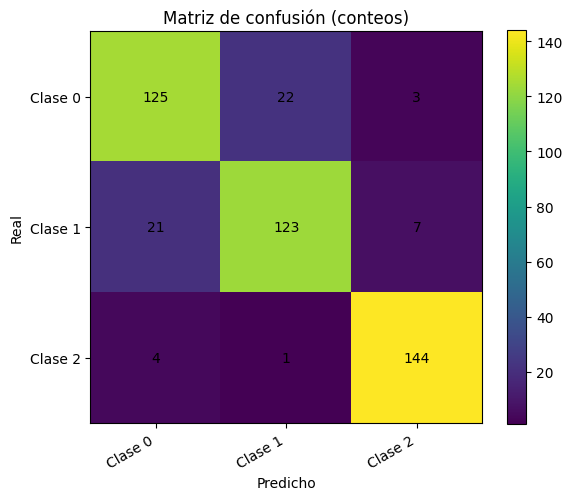

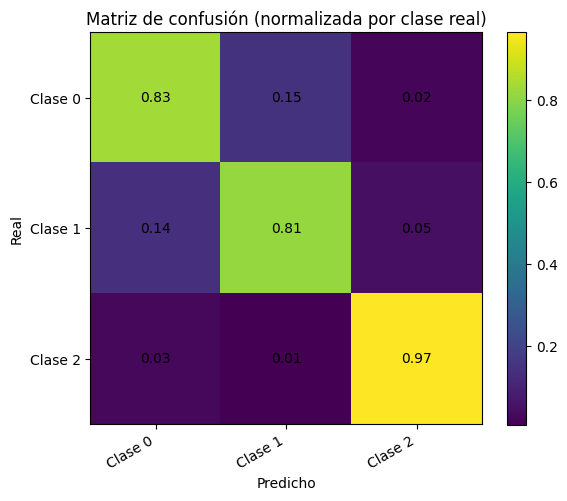

In [5]:
# =========================================================
# D) CLASIFICACIÓN MULTICLASE + MATRIZ DE CONFUSIÓN (con gráfico)
# =========================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score,
    log_loss, confusion_matrix, classification_report
)

# 1) Simular datos multiclase
Xmc, ymc = make_classification(
    n_samples=1500,
    n_features=12,
    n_informative=6,
    n_redundant=2,
    n_classes=3,
    n_clusters_per_class=1,
    class_sep=1.2,
    flip_y=0.03,
    random_state=7
)

classes = np.unique(ymc)
class_names = [f"Clase {c}" for c in classes]

Xtr, Xte, ytr, yte = train_test_split(
    Xmc, ymc, test_size=0.30, random_state=7, stratify=ymc
)

# 2) Baseline: predecir siempre la clase mayoritaria
major = pd.Series(ytr).value_counts().idxmax()
pred_base = np.full_like(yte, fill_value=major)

# Probas baseline = prior del train
priors = pd.Series(ytr).value_counts(normalize=True).sort_index()
proba_base = np.tile(priors.values, (len(yte), 1))

# 3) Modelo: Logistic Regression multiclase (multinomial)
clf_mc = LogisticRegression(
    max_iter=5000,
    solver="lbfgs",
    multi_class="multinomial"
)
clf_mc.fit(Xtr, ytr)

pred_mc = clf_mc.predict(Xte)
proba_mc = clf_mc.predict_proba(Xte)

# 4) Métricas (multiclase)
def multiclass_metrics(name, y_true, y_pred, y_proba):
    return {
        "Model": name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "BalancedAcc": balanced_accuracy_score(y_true, y_pred),
        "F1_macro": f1_score(y_true, y_pred, average="macro"),
        "F1_weighted": f1_score(y_true, y_pred, average="weighted"),
        "LogLoss": log_loss(y_true, y_proba, labels=classes),
    }

tbl_mc = pd.DataFrame([
    multiclass_metrics("Baseline (major class)", yte, pred_base, proba_base),
    multiclass_metrics("LogisticRegression (multiclass)", yte, pred_mc, proba_mc),
]).set_index("Model")

print("=== MULTICLASE: métricas en TEST ===")
display(tbl_mc)

print("\n=== Reporte detallado (LogisticRegression) ===")
print(classification_report(yte, pred_mc, target_names=class_names, digits=3))

# 5) Matriz de confusión + gráfico (conteos y normalizada)
cm = confusion_matrix(yte, pred_mc, labels=classes)
cm_norm = cm / cm.sum(axis=1, keepdims=True)

def plot_confusion(cm_show, title, fmt="{:d}", cmap=None):
    plt.figure(figsize=(6,5))
    plt.imshow(cm_show, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.xticks(range(len(classes)), class_names, rotation=30, ha="right")
    plt.yticks(range(len(classes)), class_names)

    # anotaciones
    for i in range(cm_show.shape[0]):
        for j in range(cm_show.shape[1]):
            val = cm_show[i, j]
            plt.text(j, i, fmt.format(val), ha="center", va="center")

    plt.ylabel("Real")
    plt.xlabel("Predicho")
    plt.tight_layout()
    plt.show()

# Conteos
plot_confusion(cm, "Matriz de confusión (conteos)", fmt="{:d}")

# Normalizada (por fila)
plot_confusion(cm_norm, "Matriz de confusión (normalizada por clase real)", fmt="{:.2f}")
